In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import imageio
import matplotlib.pyplot as plt

from skimage.transform import resize

def load_dataset(image_dir, mask_dir, img_ext='jpg', mask_ext='mask.png'):
    img_size = None
    msk_size = None
    images_tmp = []
    masks_tmp = []
    
    total_width, total_height = 0, 0
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.' + img_ext):
            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name.replace('.' + img_ext, '.' + mask_ext))
            
            
            image = imageio.imread(img_path)            
            #image = np.array(image)
            mask = imageio.imread(mask_path)
            #mask = np.array(mask)
                       
            total_width += image.shape[1]
            total_height += image.shape[0]      

            images_tmp.append(image)
            masks_tmp.append(mask)
    
    num_images = len(masks_tmp)
    avg_width = total_width // num_images
    avg_height = total_height // num_images

    images = []
    for image in images_tmp:
        image_resized = resize(image, (avg_height, avg_width), anti_aliasing=True)
        images.append(image_resized)    
    
    masks = []
    for mask in masks_tmp:
        mask_resized = resize(mask, (avg_height, avg_width), anti_aliasing=False)#anti_aliasing must be False for boolean images
        masks.append(mask_resized) 

    print("resize done!")
    
    images = np.array(images, dtype=np.float32) / 255.0
    masks = np.array(masks, dtype=np.float32) / 255.0
    return images, masks, (avg_width, avg_height), (avg_width, avg_height)


In [4]:
image_dir = 'myfolder/images'
mask_dir = 'myfolder/masks'
images, masks, img_size, msk_size = load_dataset(image_dir, mask_dir)

C:\Users\pc\AppData\Local\Temp\ipykernel_9808\3699574221.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)
C:\Users\pc\AppData\Local\Temp\ipykernel_9808\3699574221.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


resize done!


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (1236, 480, 640) + inhomogeneous part.

C:\Users\pc\AppData\Local\Temp\ipykernel_5900\2564036158.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(img_path)


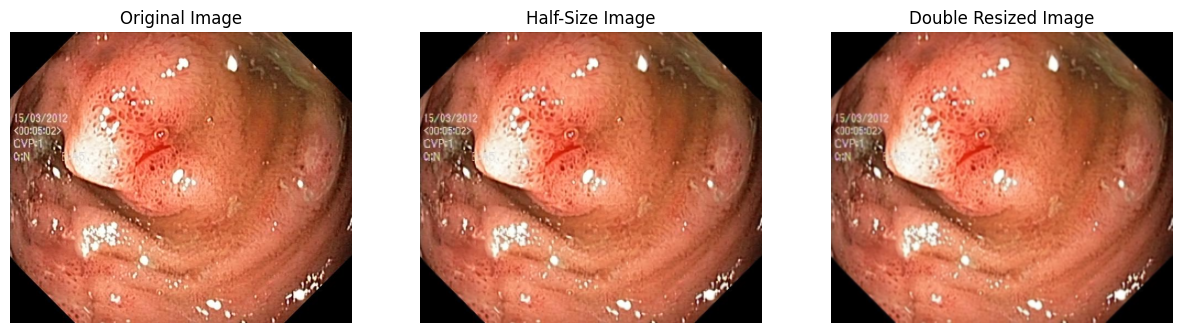

In [9]:
#Just for testing resize
import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize

# Define the image path
img_path = "C:/Users/pc/Desktop/wdir/_data/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg"

# Read the image using imageio
image = imageio.imread(img_path)

# Resize the image to half the size
half_image = resize(image, (image.shape[0] // 2, image.shape[1] // 2))

# Resize the half-size image back to twice that size
double_resized_image = resize(half_image, (half_image.shape[0] * 2, half_image.shape[1] * 2))

# Display the original, half-size, and double-resized images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(half_image)
axes[1].set_title('Half-Size Image')
axes[1].axis('off')

axes[2].imshow(double_resized_image)
axes[2].set_title('Double Resized Image')
axes[2].axis('off')

plt.show()


In [6]:
img_size

In [5]:
images.shape

(1000, 529, 622, 3)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D


def yolo_model(input_shape=(None, None, 3)):
    inputs = Input(shape=input_shape)
    
    # Downsampling
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Upsampling
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = yolo_model((img_size[0], img_size[1], 3))
model = yolo_model()
model = yolo_model((img_size[0], img_size[1], 3))


In [9]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)


In [ ]:
# Train the model
model.fit(images_train, masks_train, epochs=20, batch_size=4, validation_data=(images_test, masks_test))


Epoch 1/20
 44/123 ━━━━━━━━━━━━━━━━━━━━ 24s 314ms/step - accuracy: 0.9065 - loss: 0.2637

In [15]:
model.save('CVC-ClinicDB.h5')

In [16]:
from tensorflow.keras.models import load_model
model = load_model('CVC-ClinicDB.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


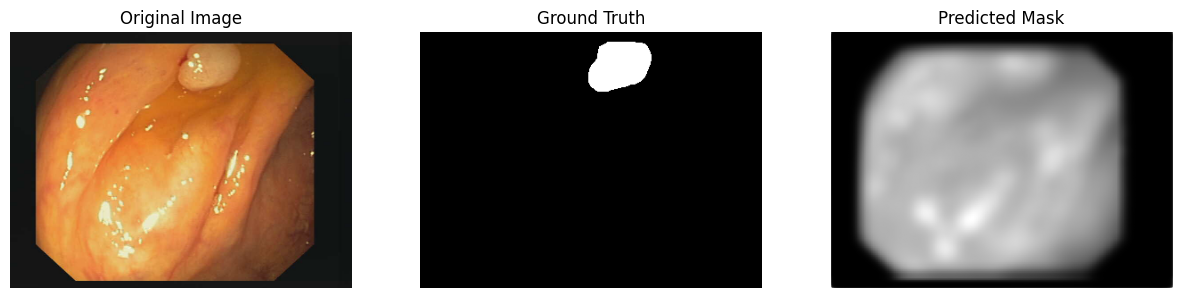

In [11]:
import matplotlib.pyplot as plt

# Select a test image
index = 0  # Change the index to visualize different test images
test_image = images_test[index]
ground_truth = masks_test[index]

predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Plot the original image, ground truth, and prediction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(test_image)
axs[0].set_title('Original Image')

axs[1].imshow(ground_truth[:, :, 0], cmap='gray')
axs[1].set_title('Ground Truth')

axs[2].imshow(predicted_mask[:, :, 0], cmap='gray')
axs[2].set_title('Predicted Mask')

for ax in axs:
    ax.axis('off')

plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
IoU: 0.0000


C:\Users\pc\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


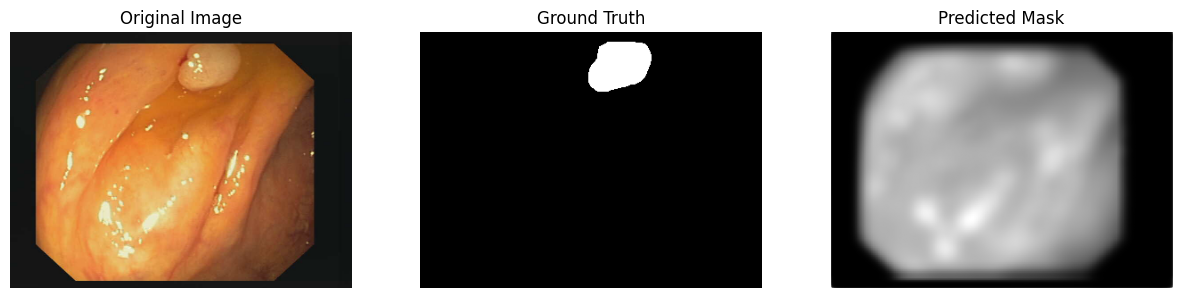

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# Define a function to calculate these metrics
def evaluate_metrics(true_mask, pred_mask, threshold=0.5):
    pred_mask = pred_mask > threshold
    true_mask = true_mask.astype(np.uint8).flatten()
    pred_mask = pred_mask.astype(np.uint8).flatten()
    
    precision = precision_score(true_mask, pred_mask)
    recall = recall_score(true_mask, pred_mask)
    f1 = f1_score(true_mask, pred_mask)
    iou = np.sum(np.logical_and(pred_mask, true_mask)) / np.sum(np.logical_or(pred_mask, true_mask))

    return precision, recall, f1, iou

# Select a test image
index = 0  # Change the index to visualize different test images
test_image = images_test[index]
ground_truth = masks_test[index]

# Predict the mask
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Evaluate the metrics
precision, recall, f1, iou = evaluate_metrics(ground_truth, predicted_mask)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"IoU: {iou:.4f}")

# Plot the original image, ground truth, and prediction
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(test_image)
axs[0].set_title('Original Image')

axs[1].imshow(ground_truth[:, :, 0], cmap='gray')
axs[1].set_title('Ground Truth')

axs[2].imshow(predicted_mask[:, :, 0], cmap='gray')
axs[2].set_title('Predicted Mask')

for ax in axs:
    ax.axis('off')

plt.show()
